#ERA5 Data Analysis

Professional analysis and visualization of ERA5 weather data.

## 📊 Contents
- **Data Overview**: Dimensions, variables, temporal coverage
- **Geographic Visualization**: Professional weather maps with Cartopy
- **Interactive Plots**: Dynamic visualizations with Plotly
- **Statistical Analysis**: Time series, spatial distribution, extremes
- **Regional Comparison**: Multi-region analysis
- **Animation**: Temporal evolution of weather patterns 
- **Model Comparison**: Compare prediction results

## 🛠️ Dependencies
```bash
# Optional dependencies for enhanced visualization
pip install cartopy plotly kaleido ipywidgets
```

**Note**: The notebook works without optional dependencies, falling back to basic matplotlib.

## 1. Environment Setup
**环境设置**：导入必要的Python库（xarray、matplotlib、cartopy等）和配置可视化参数

In [14]:
# Import libraries
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import plotly.graph_objects as go
import plotly.express as px
# Interactive widgets
from ipywidgets import interact, IntSlider
from IPython.display import display

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'sans-serif'

print("✅ Environment setup complete")


✅ Environment setup complete


## 2. Load ERA5 Data
**加载ERA5数据**：从Google Cloud Storage读取ERA5全球再分析气象数据集（1959-2021年），包含温度、风速、气压等38个气象变量

In [2]:
# Load ERA5 data
DATA_PATH = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'

print("📥 Loading ERA5 data...")
ds = xr.open_zarr(DATA_PATH)
print("✅ Data loaded!\n")

# Display basic information
print("="*80)
print("Dataset Information")
print("="*80)
print(f"Time range: {str(ds.time.values[0])[:10]} to {str(ds.time.values[-1])[:10]}")
print(f"Time steps: {len(ds.time)}")
print(f"Spatial resolution: {len(ds.latitude)}x{len(ds.longitude)} (lat x lon)")
print(f"Latitude range: [{float(ds.latitude.min()):.2f}, {float(ds.latitude.max()):.2f}]")
print(f"Longitude range: [{float(ds.longitude.min()):.2f}, {float(ds.longitude.max()):.2f}]")
print(f"\nAvailable variables ({len(ds.data_vars)}):")
for var in ds.data_vars:
    shape = ds[var].shape
    print(f"  • {var:30s} {shape}")

📥 Loading ERA5 data...
✅ Data loaded!

Dataset Information
Time range: 1959-01-01 to 2021-12-31
Time steps: 92044
Spatial resolution: 32x64 (lat x lon)
Latitude range: [-87.19, 87.19]
Longitude range: [0.00, 354.38]

Available variables (38):
  • 10m_u_component_of_wind        (92044, 64, 32)
  • 10m_v_component_of_wind        (92044, 64, 32)
  • 10m_wind_speed                 (92044, 64, 32)
  • 2m_temperature                 (92044, 64, 32)
  • angle_of_sub_gridscale_orography (64, 32)
  • anisotropy_of_sub_gridscale_orography (64, 32)
  • geopotential                   (92044, 13, 64, 32)
  • geopotential_at_surface        (64, 32)
  • high_vegetation_cover          (64, 32)
  • lake_cover                     (64, 32)
  • lake_depth                     (64, 32)
  • land_sea_mask                  (64, 32)
  • low_vegetation_cover           (64, 32)
  • mean_sea_level_pressure        (92044, 64, 32)
  • sea_ice_cover                  (92044, 64, 32)
  • sea_surface_temperature        

## 3. Data Selection
**数据选择**：选择特定的时间段（如2020年）和感兴趣的气象变量（如2米温度）进行后续分析

In [3]:
# Select time period and variable
TIME_SLICE = slice('2020-01-01', '2020-12-31')
ANALYSIS_VAR = '2m_temperature'  # Options: 'geopotential', '10m_u_component_of_wind', etc.

# Extract data
ds_analysis = ds.sel(time=TIME_SLICE)
var_data = ds_analysis[ANALYSIS_VAR]

print(f"Analysis variable: {ANALYSIS_VAR}")
print(f"Data shape: {var_data.shape}")
print(f"Time steps: {len(var_data.time)}")
print(f"Value range: [{float(var_data.min()):.2f}, {float(var_data.max()):.2f}]")

Analysis variable: 2m_temperature
Data shape: (1464, 64, 32)
Time steps: 1464
Value range: [198.87, 322.44]


## 4. Geographic Visualization
**地理可视化**：使用Cartopy库在全球地图投影上绘制气象数据的空间分布，展示某一时刻的全球天气状况

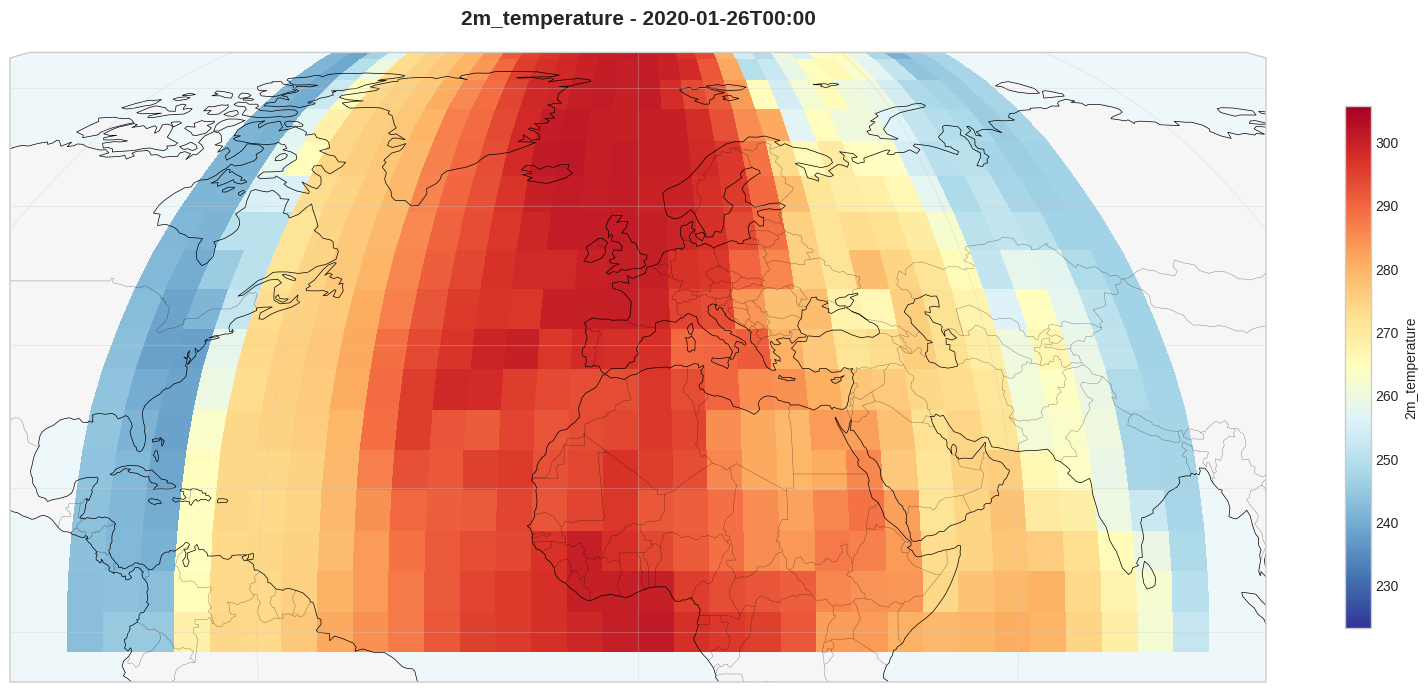


💡 Note: Map edges may appear incomplete due to ERA5 data coverage:
   • Latitude: ±87.19° (polar regions excluded)
   • Longitude: 0-354.38° (small gap near dateline)


In [4]:
def plot_global_map(data, title="Global Weather Map", vmin=None, vmax=None, cmap='RdYlBu_r'):
    """Plot professional weather map with Cartopy"""
    # if not CARTOPY_AVAILABLE:
    #     # Basic matplotlib fallback
    #     fig, ax = plt.subplots(figsize=(14, 7))
    #     data.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax)
    #     ax.set_title(title, fontsize=14, fontweight='bold')
    #     ax.set_xlabel('Longitude', fontsize=11)
    #     ax.set_ylabel('Latitude', fontsize=11)
    #     return fig
    
    # Professional map with Cartopy
    fig = plt.figure(figsize=(16, 9))
    ax = plt.axes(projection=ccrs.Robinson())
    
    # Add geographic features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.2)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)
    ax.gridlines(draw_labels=False, alpha=0.3)
    
    # Plot data
    im = data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        add_colorbar=True,
        cbar_kwargs={'shrink': 0.6, 'pad': 0.05, 'label': ANALYSIS_VAR}
    )
    
    ax.set_title(title, fontsize=15, fontweight='bold', pad=20)
    plt.tight_layout()
    return fig

# Example: Plot global distribution at a specific time
sample_time = var_data.isel(time=100)
fig = plot_global_map(
    sample_time,
    title=f"{ANALYSIS_VAR} - {str(sample_time.time.values)[:16]}",
    cmap='RdYlBu_r'
)
plt.show()

print("\n💡 Note: Map edges may appear incomplete due to ERA5 data coverage:")
print("   • Latitude: ±87.19° (polar regions excluded)")
print("   • Longitude: 0-354.38° (small gap near dateline)")

## 5. Statistical Analysis
**统计分析**：计算气象变量的时间统计特征（均值、标准差、最大值、最小值），并生成空间分布图展示气候特征

In [6]:
# Calculate statistics
print("="*80)
print(f"Statistical Analysis for {ANALYSIS_VAR}")
print("="*80)

# Temporal statistics
temporal_mean = var_data.mean(dim='time')
temporal_std = var_data.std(dim='time')
temporal_max = var_data.max(dim='time')
temporal_min = var_data.min(dim='time')

print(f"\nTemporal statistics (global average):")
print(f"  Mean:   {float(temporal_mean.mean()):.2f}")
print(f"  Std:    {float(temporal_std.mean()):.2f}")
print(f"  Max:    {float(temporal_max.max()):.2f}")
print(f"  Min:    {float(temporal_min.min()):.2f}")

# Spatial mean time series
spatial_mean_ts = var_data.mean(dim=['latitude', 'longitude'])

print(f"\nSpatial mean time series:")
print(f"  Mean:   {float(spatial_mean_ts.mean()):.2f}")
print(f"  Change: {float(spatial_mean_ts[-1] - spatial_mean_ts[0]):.2f}")

Statistical Analysis for 2m_temperature

Temporal statistics (global average):
  Mean:   279.31
  Std:    5.79
  Max:    322.44
  Min:    198.87

Spatial mean time series:
  Mean:   279.31
  Change: 0.46


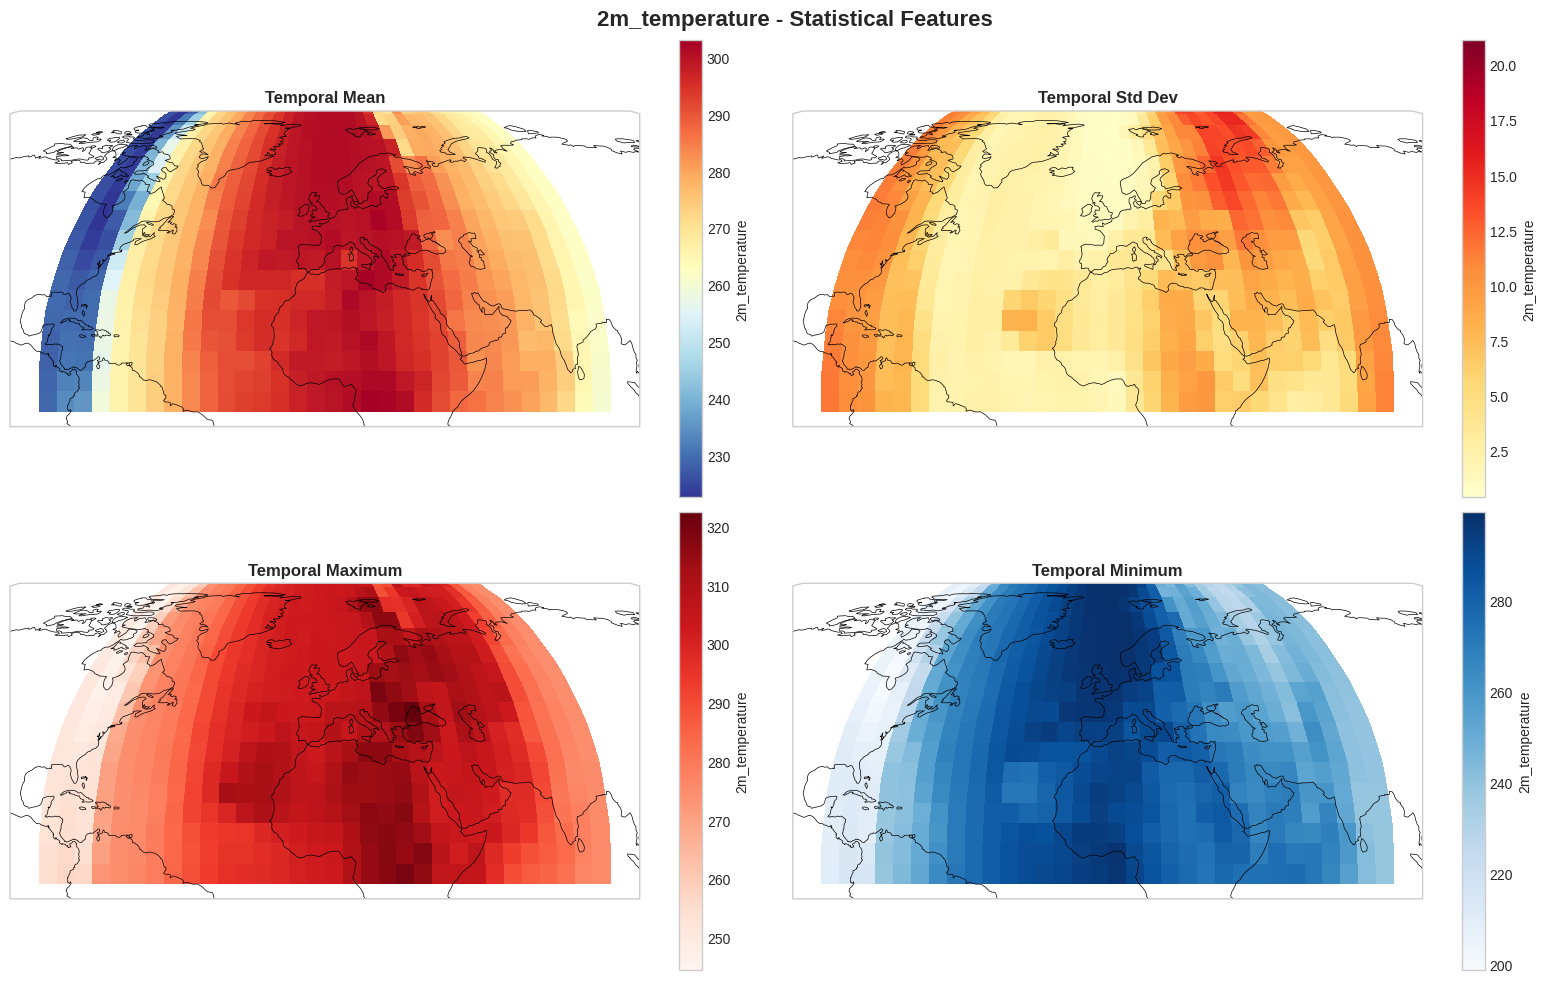

In [7]:
# Visualize statistical features
fig = plt.figure(figsize=(16, 10))

def add_map_subplot(position, data, title, cmap):
    ax = plt.subplot(2, 2, position, projection=ccrs.Robinson())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=True)
    ax.set_title(title, fontweight='bold', fontsize=12)

add_map_subplot(1, temporal_mean, 'Temporal Mean', 'RdYlBu_r')
add_map_subplot(2, temporal_std, 'Temporal Std Dev', 'YlOrRd')
add_map_subplot(3, temporal_max, 'Temporal Maximum', 'Reds')
add_map_subplot(4, temporal_min, 'Temporal Minimum', 'Blues')

plt.suptitle(f'{ANALYSIS_VAR} - Statistical Features', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## 6. Time Series Analysis
**时间序列分析**：绘制全球平均气象变量随时间的变化曲线，使用移动平均平滑数据以观察长期趋势和季节性变化

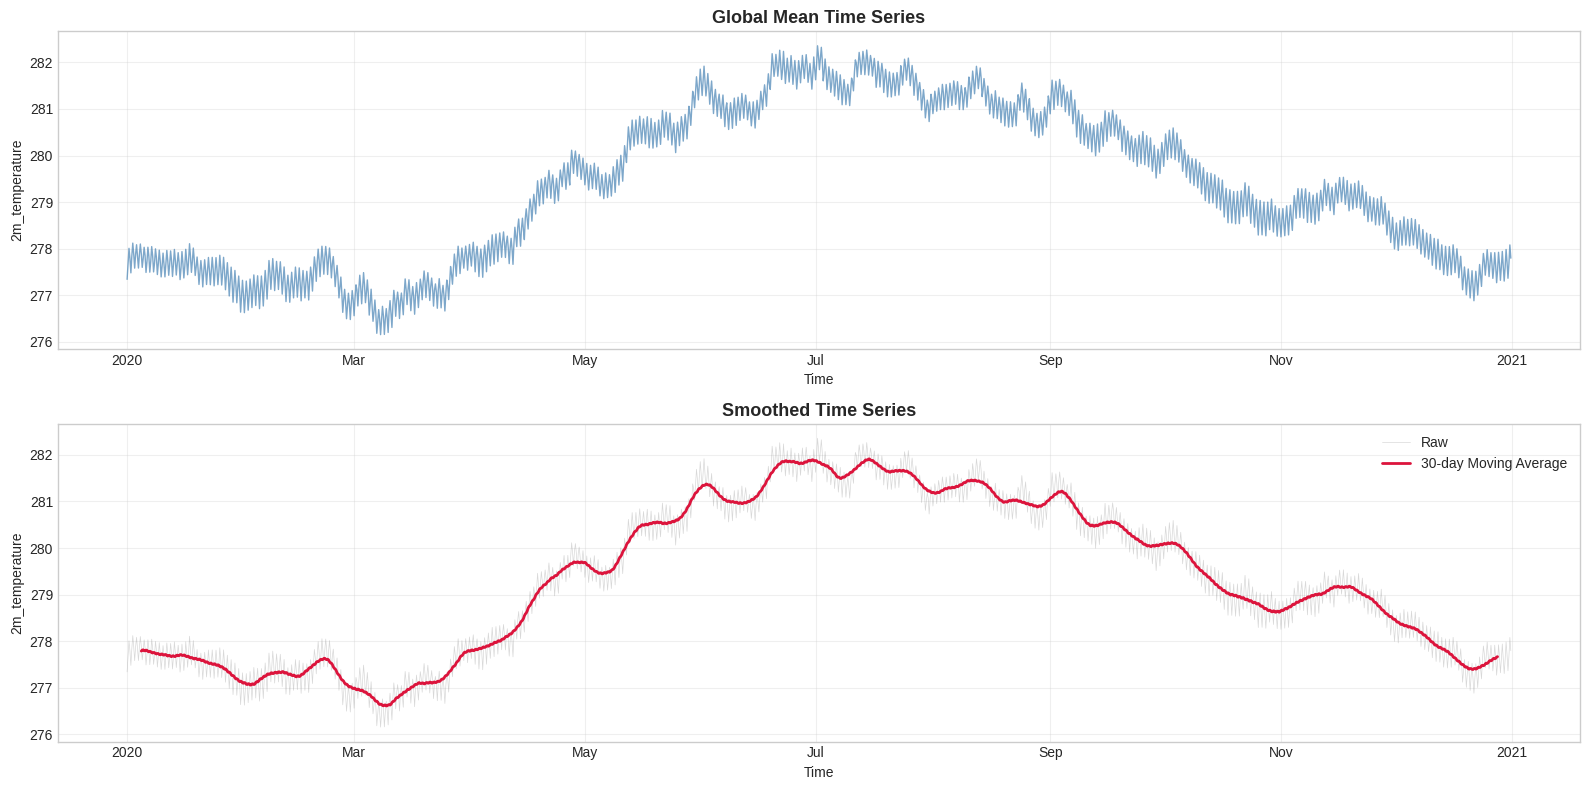

In [8]:
# Global average time series
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Raw time series
ax = axes[0]
spatial_mean_ts.plot(ax=ax, linewidth=1, alpha=0.7, color='steelblue')
ax.set_title('Global Mean Time Series', fontweight='bold', fontsize=13)
ax.set_xlabel('Time')
ax.set_ylabel(ANALYSIS_VAR)
ax.grid(True, alpha=0.3)

# Smoothed
ax = axes[1]
spatial_mean_ts.plot(ax=ax, linewidth=0.5, alpha=0.3, label='Raw', color='gray')
ma_30 = spatial_mean_ts.rolling(time=30, center=True).mean()
ma_30.plot(ax=ax, linewidth=2, label='30-day Moving Average', color='crimson')
ax.set_title('Smoothed Time Series', fontweight='bold', fontsize=13)
ax.set_xlabel('Time')
ax.set_ylabel(ANALYSIS_VAR)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Interactive Visualization (Plotly)
**交互式可视化**：使用Plotly创建可交互的图表（可缩放、平移、悬停查看数据），包括时间序列图和时间-纬度热力图

In [9]:
# Interactive time series
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=spatial_mean_ts.time.values,
    y=spatial_mean_ts.values,
    mode='lines',
    name='Global Mean',
    line=dict(width=1, color='steelblue'),
    opacity=0.7
))

ma = spatial_mean_ts.rolling(time=30, center=True).mean()
fig.add_trace(go.Scatter(
    x=ma.time.values,
    y=ma.values,
    mode='lines',
    name='30-day MA',
    line=dict(width=3, color='crimson')
))

fig.update_layout(
    title=f'{ANALYSIS_VAR} - Interactive Time Series (zoom & pan enabled)',
    xaxis_title='Time',
    yaxis_title=ANALYSIS_VAR,
    hovermode='x unified',
    height=500,
    template='plotly_white'
)

fig.show()


In [10]:
# Interactive heatmap (time-latitude)
lon_slice = var_data.isel(longitude=32)

fig = go.Figure(data=go.Heatmap(
    z=lon_slice.values.T,
    x=lon_slice.time.values,
    y=lon_slice.latitude.values,
    colorscale='RdYlBu_r',
    colorbar=dict(title=ANALYSIS_VAR)
))

fig.update_layout(
    title=f'{ANALYSIS_VAR} - Time-Latitude Heatmap (interactive)',
    xaxis_title='Time',
    yaxis_title='Latitude',
    height=600,
    template='plotly_white'
)

fig.show()


## 8. Regional Comparison
**区域对比**：选择多个关键地理区域（北美、欧洲、东亚、南美等），对比不同区域的气象变量变化特征和差异

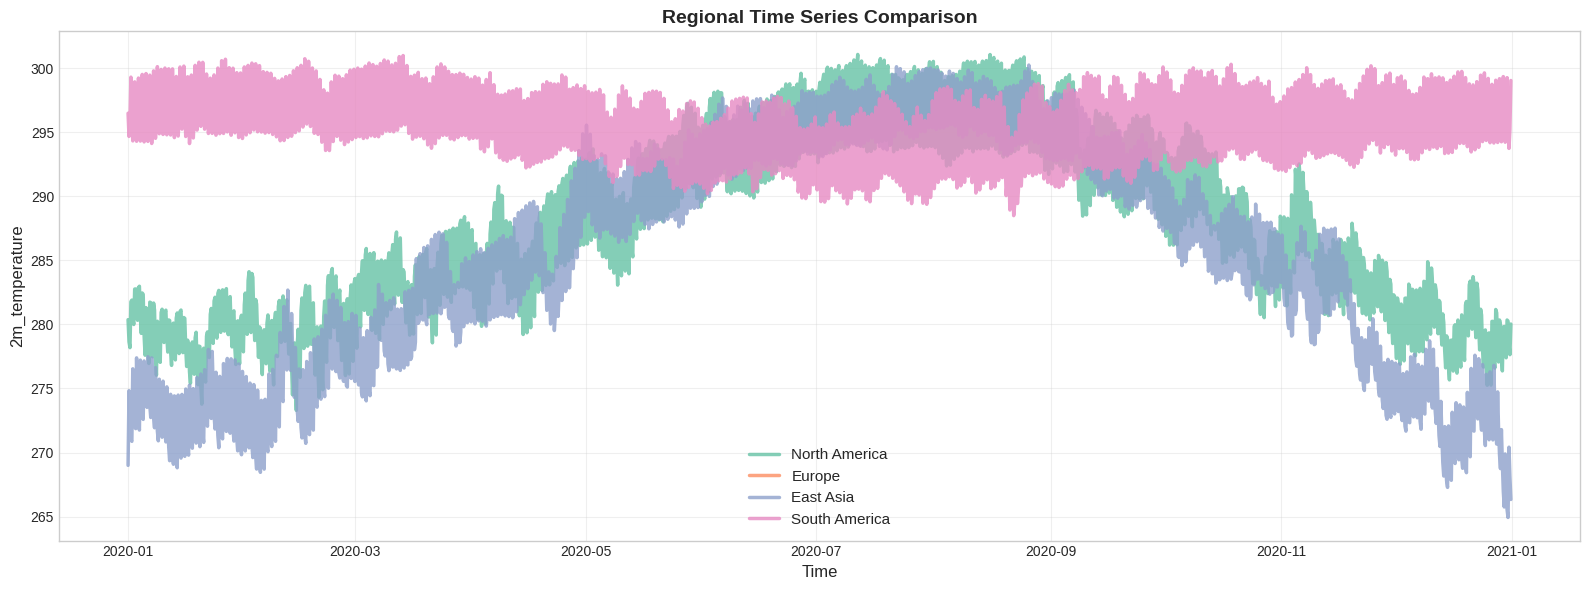

In [11]:
# Define key regions
regions = {
    'North America': {'lat': slice(25, 50), 'lon': slice(235, 290)},
    'Europe': {'lat': slice(35, 60), 'lon': slice(350, 40)},
    'East Asia': {'lat': slice(20, 50), 'lon': slice(100, 145)},
    'South America': {'lat': slice(-40, 10), 'lon': slice(280, 320)},
}

# Calculate regional time series
region_ts = {}
for name, bounds in regions.items():
    try:
        region_data = var_data.sel(
            latitude=bounds['lat'],
            longitude=bounds['lon']
        )
        region_ts[name] = region_data.mean(dim=['latitude', 'longitude'])
    except Exception as e:
        print(f"⚠️  Cannot extract region: {name} - {e}")

# Plot comparison
fig, ax = plt.subplots(figsize=(16, 6))

colors = sns.color_palette("Set2", len(region_ts))
for (name, ts), color in zip(region_ts.items(), colors):
    ax.plot(ts.time.values, ts.values, label=name, linewidth=2.5, alpha=0.8, color=color)

ax.set_title('Regional Time Series Comparison', fontweight='bold', fontsize=14)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel(ANALYSIS_VAR, fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Animation
**动画展示**：创建动态动画，在全球地图上按时间顺序播放气象场的演变过程，直观展示天气模式随时间的变化规律（如季节变化、天气系统移动等）

In [17]:
# 交互式动画 - 使用滑块控制时间

limit_100_val_data = var_data.isel(time=slice(0, 100)) 
def plot_time_step(time_index):
    """绘制指定时间步的全球地图"""
    frame_data = limit_100_val_data.isel(time=time_index)
    time_str = str(frame_data.time.values)[:16]
    
    # 计算全局颜色范围，保持一致性
    vmin = float(var_data.min())
    vmax = float(var_data.max())
    
    # 创建地图
    fig = plt.figure(figsize=(16, 8))
    ax = plt.axes(projection=ccrs.Robinson())
    
    # 添加地理特征
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.2)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)
    ax.gridlines(draw_labels=False, alpha=0.3)
    
    # 绘制数据
    im = frame_data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap='RdYlBu_r',
        vmin=vmin,
        vmax=vmax,
        add_colorbar=True,
        cbar_kwargs={
            'shrink': 0.6, 
            'pad': 0.05, 
            'label': f'{ANALYSIS_VAR}',
            'orientation': 'horizontal'
        }
    )
    
    ax.set_title(f'{ANALYSIS_VAR} - {time_str}\n(scroll the slider to see different times)', 
                 fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()

print("🎬 交互式时间动画")
print(f"📊 共有 {len(limit_100_val_data.time)} 个时间步")
print("💡 拖动下方滑块来查看不同时间的全球天气分布\n")

# 创建交互式滑块
interact(
    plot_time_step,
    time_index=IntSlider(
        min=0, 
        max=len(limit_100_val_data.time)-1, 
        step=1, 
        value=0,
        description='时间步:',
        continuous_update=False,  # 只在释放滑块时更新，避免卡顿
        style={'description_width': '80px'},
        layout={'width': '80%'}
    )
)

🎬 交互式时间动画
📊 共有 100 个时间步
💡 拖动下方滑块来查看不同时间的全球天气分布



interactive(children=(IntSlider(value=0, continuous_update=False, description='时间步:', layout=Layout(width='80%…

<function __main__.plot_time_step(time_index)>

## 12. Analysis Summary
**分析总结**：汇总整个分析的关键信息，包括数据概览、统计特征、模型性能等，并提示数据集的特性和局限性

In [32]:
# Generate summary
print("="*80)
print("ERA5 Data Analysis Summary")
print("="*80)
print(f"\n📊 Data Information:")
print(f"   • Variable: {ANALYSIS_VAR}")
print(f"   • Time range: {str(var_data.time.values[0])[:10]} to {str(var_data.time.values[-1])[:10]}")
print(f"   • Time steps: {len(var_data.time)}")
print(f"   • Spatial resolution: {len(var_data.latitude)}x{len(var_data.longitude)}")
print(f"   • Lat range: [{float(var_data.latitude.min()):.2f}, {float(var_data.latitude.max()):.2f}]")
print(f"   • Lon range: [{float(var_data.longitude.min()):.2f}, {float(var_data.longitude.max()):.2f}]")

print(f"\n📈 Statistical Features:")
print(f"   • Global mean: {float(var_data.mean()):.2f}")
print(f"   • Global std:  {float(var_data.std()):.2f}")
print(f"   • Value range: [{float(var_data.min()):.2f}, {float(var_data.max()):.2f}]")
print(f"   • Trend: {float(spatial_mean_ts[-1] - spatial_mean_ts[0]):.2f}")


print(f"\n✅ Analysis complete!")
print("="*80)

print(f"\n💡 Notes:")
print("   • ERA5 data has limited polar coverage (±87.19°)")
print("   • Longitude coverage: 0-354.38° (small gap near dateline)")
print("   • This is normal for this dataset resolution")

ERA5 Data Analysis Summary

📊 Data Information:
   • Variable: 2m_temperature
   • Time range: 2020-01-01 to 2020-12-31
   • Time steps: 1464
   • Spatial resolution: 32x64
   • Lat range: [-87.19, 87.19]
   • Lon range: [0.00, 354.38]

📈 Statistical Features:
   • Global mean: 279.31
   • Global std:  20.64
   • Value range: [198.87, 322.44]
   • Trend: 0.46

✅ Analysis complete!

💡 Notes:
   • ERA5 data has limited polar coverage (±87.19°)
   • Longitude coverage: 0-354.38° (small gap near dateline)
   • This is normal for this dataset resolution
